# Module 3 - Programming Assignment

In [4]:
%matplotlib inline

from __future__ import division

import matplotlib.pyplot as plt
import networkx as nx

## CSP: Map Coloring

This program uses **Constraint Satisfaction Problems** to color maps. As we know from the [Four Color Theorem](http://en.wikipedia.org/wiki/Four_color_theorem) any division of a plane into contiguous regions can be colored such that no two adjacent regions are the same color by using only four colors.

From the book, we know that we can translate this problem into a CSP where the map is represented as a [planar graph](http://en.wikipedia.org/wiki/Planar_graph) and the goal is to color all the nodes such that no adjacent nodes are colored the same color.

As with most AI problems, this requires us to figure out how best to represent the problem--and the solution--given the high and low level data structures and types at our disposal. For this problem, we'll settle on a Dict which contains at least two keys: "nodes" which is an *ordered* List of Strings that represents each node or vertex in the planar graph and "edges" which contains a List of Tuples that represent edges between nodes. The Tuples are of ints that represent the index of the node in the "nodes" list.

Using this system, and adding a "coordinates" key with abstract drawing coordinates of each node for NetworkX, we can represent the counties of Connecticut like so:

In [5]:
connecticut = { "nodes": ["Fairfield", "Litchfield", "New Haven", "Hartford", "Middlesex", "Tolland", "New London", "Windham"],
                "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)],
                "coordinates": [( 46, 52), ( 65,142), (104, 77), (123,142), (147, 85), (162,140), (197, 94), (217,146)]}
print connecticut

{'nodes': ['Fairfield', 'Litchfield', 'New Haven', 'Hartford', 'Middlesex', 'Tolland', 'New London', 'Windham'], 'edges': [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (3, 6), (4, 6), (5, 6), (5, 7), (6, 7)], 'coordinates': [(46, 52), (65, 142), (104, 77), (123, 142), (147, 85), (162, 140), (197, 94), (217, 146)]}


The coordinates permit us to use NetworkX to draw the graph. We'll add a helper function for this, `draw_map`, which takes our planar_map, a figure size in abstract units, and a List of color assignments in the same order as the nodes in the planar_map.  The underlying drawings are made by matplotlib using NetworkX on top of it. Incidentally, the positions just make the map "work out" on NetworkX/matplotlib.

The size parameter is actually inches wide by inches tall (8, 10) is an 8x10 sheet of paper. Why doesn't a chart cover up the whole screen then? It's adjusted by dpi. On high resolution monitors, 300 dpi with 8x10 inches might only take up a fraction of that space. 

A default value for `color_assignments` is provided, `None`, that simply colors all the nodes red. Otherwise, `color_assignments` must be a `List of Tuples` where each `Tuple` is a node name and assigned color. The order of `color_assignments` must be the same as the order of `"nodes"` in the `planar_map`.

In [17]:
def draw_map(planar_map, size, color_assignments=None):
    def as_dictionary(a_list):
        dct = {}
        for i, e in enumerate(a_list):
            dct[i] = e
        return dct
    
    G = nx.Graph()
    
    labels = as_dictionary(planar_map[ "nodes"])
    pos = as_dictionary(planar_map["coordinates"])
    
    nodes = [n for n in range(0, len(planar_map[ "nodes"]))]

    if color_assignments:
        colors = [c for n, c in color_assignments]
    else:
        colors = ['red' for c in range(0,len(planar_map[ "nodes"]))]

    G.add_nodes_from( nodes)
    G.add_edges_from( planar_map[ "edges"])

    plt.figure( figsize=size, dpi=600)

    nx.draw( G, node_color = colors, with_labels = True, labels = labels, pos = pos)

Using this function, we can draw `connecticut`:

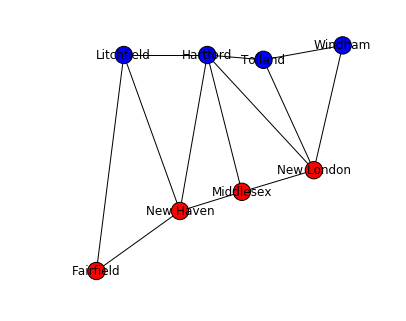

In [10]:
draw_map( connecticut, (5,4), [("Fairfield", "red"), ("Litchfield", "blue"), ("New Haven", "red"), ("Hartford", "blue"),
                               ("Middlesex", "red"), ("Tolland", "blue"), ("New London", "red"), ("Windham", "blue")])

This coloring obviously has some problems! The following program fixes them by implmenting algorithms dicussed in this module.

## Which CSP Algorithms?

This program implements **backtracking** and **forward checking**.  It also implements **Minimum Remaining Values**  and **Least Constraining Value**. Ties are broken in ascending order (least to most).

Elements implemented:

    backtracking: Yes
    forward checking: Yes
    minimum remaining values: Yes
    degree heuristic: No
    least contraining value: Yes

The main function takes the following form:

```python
def color_map( planar_map, colors, trace=False)
```

where `planar_map` has the format described above, colors is a List of Strings denoting the colors to use and `trace` operates as described in the next paragraph. It should return a List of Tuples where each Tuple is of the form `( Node Name, Color)` in the same order as the `node` entry in the planar_map. For example, if we had `["A", "B"]` as nodes and `["Yellow", "Green"]` as colors, the function might return `[("A", "Yellow"), ("B", "Green")]`. List comprehension can be used to extract the colors in order to feed them to `draw_map`. If a coloring cannot be found, return `None`.

The function also will take an optional argument, `trace`, with a default value of `False`. 

If `trace` is set to `True` the program will print out *traces* (or debugging) statements that show what it is currently doing (in terms of the implemented algorithms). 

-----

**Initialize node information map**

This function initializes a dictionary, node_info_map, that will be used throughout the execution of the algorithm to keep track of which colors are available to each node (have not been removed by forward checking), and which nodes have been assigned.  It takes the form of:

{ node: { "colors": [list of colors], "assigned": True|False} }

In [ ]:
def initialize_node_info_map(planar_map, colors):
    node_info_map = {}
    for node in planar_map["nodes"]:
        node_info_map[node] = {"colors" : [], "assigned": False}
        node_info_map[node]["colors"] = copy.deepcopy(colors)
    
    return node_info_map

**Check if node is assigned**

This function checks whether a node has been assigned and is used to check whether or not a complete assignment has been made for the constraint satisaction problem

In [19]:
def node_assigned(node, assignments):
    for assignment in assignments:
        if assignment[0] == node:
            return True
            
    return False 

**Check if assignment is complete**

This function checks whether a the assignment is complete for the constraint satisfaction problem.  It checks whether each node in the planar_map has been assigned a color

In [ ]:
def check_complete_assignment(assignments, planar_map, trace):
    if trace:
        print 'Checking for a complete assignment'
    for node in planar_map["nodes"]:
        if not node_assigned(node, assignments):
            if trace:
                print '\tAssignment not complete, continuing algorithm\n'
            return False
    
    if trace:
        print '\tAssignment is complete\n'
    return True 

**Select unassigned variable using Minimum Remaining Values**

This function selects the next unassigned variable using Minimum Remaining Values. It does so by using the node_info_map to only examine variables that are not yet assigned, as well as to pick the variable with the minimum remaining values.  This is done by choosing the node in the node_info_map with the least number of colors in its "colors" list where the node value for "assigned" is False.  Ties are broken by ascending order of node name.

In [ ]:
def select_unassigned_variable(node_info_map, colors, trace):
    if trace:
        print 'Selecting an unassigned variable using minimum remaining values, ties broken in ascending order'

    mininimum_remaining = len(colors)
        
    for node, node_info in node_info_map.iteritems():
        colors = node_info["colors"]
        if not node_info["assigned"]:
            num_remaining = len(colors)
            if num_remaining < mininimum_remaining and num_remaining > 0:
                mininimum_remaining = num_remaining
    
    selected_nodes = []
    for node, node_info in node_info_map.iteritems():
        colors = node_info["colors"]
        if not node_info["assigned"]:
            if len(colors) == mininimum_remaining:
                selected_nodes.append(node)
    
    if selected_nodes:
        selected_nodes.sort()
        
        if trace:
            print '\tLeast value node found with minimum remaining values: ', selected_nodes[0], '\n'
        return selected_nodes[0]
    
    return None

**Get number of constraints for a variable**

This function gets the number of constraints on a variable given the planar_map, the node_info_map, and a color.  It does so by examining the nodes connected to the given variable using the planar_map.  Then, it examines the colors available to each connected node using the node_info_map, and for each connected node that also has the given color, this adds to the constraint count, which is returned.  This function is used as a helper to implement Least Constraining Value to select a value for a variable.

In [ ]:
def get_num_constraints(variable, planar_map, node_info_map, color):
    node_index = planar_map["nodes"].index(variable)
    
    num_constraints = 0
    for edge in planar_map["edges"]:
        other_node_index = None
        if edge[0] == node_index:
            other_node_index = edge[1]
        
        elif edge[1] == node_index:
            other_node_index = edge[0]   
        
        if other_node_index:   
            other_node = planar_map["nodes"][other_node_index]
            for other_color in node_info_map[other_node]["colors"]:
                if color == other_color:
                    num_constraints += 1
                        
    return num_constraints

**Order domain values using Least Constraining Value**

This function orders domain values using least constraining value by using the get_num_constraints function for each value of the given variable.  As the number of constraints for each variable is found, the variable is inserted into a priority queue ordered by number of constraints.  The priority queue is implemented as a list of tuples in format [(color, num_constraints)]. Ties are broken in ascending order.

In [ ]:
def order_domain_values(variable, node_info_map, planar_map, trace): 
    if trace:
        print 'Ordering domain values using Least Constraining Value'
    
    priority_queue = [] 
    for color in node_info_map[variable]["colors"]:   
        num_constraints = get_num_constraints(variable, planar_map, node_info_map, color)
        
        for i in range(len(priority_queue)):
            if num_constraints < priority_queue[i][1]:
                priority_queue.insert(i, (color, num_constraints))
                
        if (color, num_constraints) not in priority_queue:
            priority_queue.append((color, num_constraints))
            
    ordered_colors = [item[0] for item in priority_queue]
    
    if trace:
        print '\tOrdered domain values:', ordered_colors, '\n'    
    return ordered_colors

**Get connected nodes**

Given a variable and the planar_map, this function gets the nodes connected to the variable.  It does so by examining the edges in the planar map, and finding which edges have the variable as an endpoint.  To do so, it must get the node index by looking at the nodes in the planar_map.  For each edge that has the variable as an endpoint, the corresponding endpoint is added to a list.  A list of connected_nodes is returned.  This function is used to check whether an assignment is consistent, to determine whether a forward check would be successful, to execute forward checking, and to remove forward checking.

In [ ]:
def get_connected_nodes(variable, planar_map):
    connected_nodes = []
    node_index = planar_map["nodes"].index(variable)
    
    for edge in planar_map["edges"]:
        other_node_index = None
        if edge[0] == node_index:
            other_node_index = edge[1]
        
        elif edge[1] == node_index:
            other_node_index = edge[0] 
        
        if other_node_index:
            connected_node = planar_map["nodes"][other_node_index]
            connected_nodes.append(connected_node)
        
    return connected_nodes


-----

In [18]:
def color_map(planar_map, colors, trace=False):
    assignments = backtracking_search(planar_map, colors, trace)
    return assignments

## Problem 1. Color Connecticut Using Your Solution

In [ ]:
connecticut_colors = color_map( connecticut, ["red", "blue", "green", "yellow"], trace=True)

Using the "edges" list from the connecticut map, we can test to see if each pair of adjacent nodes is indeed colored differently:

In [ ]:
edges = connecticut["edges"]
nodes = connecticut[ "nodes"]
colors = connecticut_colors
COLOR = 1

for start, end in edges:
    try:
        assert colors[ start][COLOR] != colors[ end][COLOR]
    except AssertionError:
        print "%s and %s are adjacent but have the same color." % (nodes[ start], nodes[ end])

In [ ]:
draw_map( connecticut, (5,4), connecticut_colors)

In [ ]:
connecticut_colors = color_map( connecticut, ["red", "blue", "green"], trace=True)
if connecticut_colors:
    draw_map( connecticut, (5,4), connecticut_colors)

## Problem 2. Color Europe Using Your solution

In [5]:
europe = {
    "nodes":  ["Iceland", "Ireland", "United Kingdom", "Portugal", "Spain",
                 "France", "Belgium", "Netherlands", "Luxembourg", "Germany",
                 "Denmark", "Norway", "Sweden", "Finland", "Estonia",
                 "Latvia", "Lithuania", "Poland", "Czech Republic", "Austria",
                 "Liechtenstein", "Switzerland", "Italy", "Malta", "Greece",
                 "Albania", "Macedonia", "Kosovo", "Montenegro", "Bosnia Herzegovina",
                 "Serbia", "Croatia", "Slovenia", "Hungary", "Slovakia",
                 "Belarus", "Ukraine", "Moldova", "Romania", "Bulgaria",
                 "Cyprus", "Turkey", "Georgia", "Armenia", "Azerbaijan",
                 "Russia" ], 
    "edges": [(0,1), (0,2), (1,2), (2,5), (2,6), (2,7), (2,11), (3,4),
                 (4,5), (4,22), (5,6), (5,8), (5,9), (5,21), (5,22),(6,7),
                 (6,8), (6,9), (7,9), (8,9), (9,10), (9,12), (9,17), (9,18),
                 (9,19), (9,21), (10,11), (10,12), (10,17), (11,12), (11,13), (11,45), 
                 (12,13), (12,14), (12,15), (12,17), (13,14), (13,45), (14,15),
                 (14,45), (15,16), (15,35), (15,45), (16,17), (16,35), (17,18),
                 (17,34), (17,35), (17,36), (18,19), (18,34), (19,20), (19,21), 
                 (19,22), (19,32), (19,33), (19,34), (20,21), (21,22), (22,23),
                 (22,24), (22,25), (22,28), (22,29), (22,31), (22,32), (24,25),
                 (24,26), (24,39), (24,40), (24,41), (25,26), (25,27), (25,28),
                 (26,27), (26,30), (26,39), (27,28), (27,30), (28,29), (28,30),
                 (29,30), (29,31), (30,31), (30,33), (30,38), (30,39), (31,32),
                 (31,33), (32,33), (33,34), (33,36), (33,38), (34,36), (35,36),
                 (35,45), (36,37), (36,38), (36,45), (37,38), (38,39), (39,41),
                 (40,41), (41,42), (41,43), (41,44), (42,43), (42,44), (42,45),
                 (43,44), (44,45)],
    "coordinates": [( 18,147), ( 48, 83), ( 64, 90), ( 47, 28), ( 63, 34),
                   ( 78, 55), ( 82, 74), ( 84, 80), ( 82, 69), (100, 78),
                   ( 94, 97), (110,162), (116,144), (143,149), (140,111),
                   (137,102), (136, 95), (122, 78), (110, 67), (112, 60),
                   ( 98, 59), ( 93, 55), (102, 35), (108, 14), (130, 22),
                   (125, 32), (128, 37), (127, 40), (122, 42), (118, 47),
                   (127, 48), (116, 53), (111, 54), (122, 57), (124, 65),
                   (146, 87), (158, 65), (148, 57), (138, 54), (137, 41),
                   (160, 13), (168, 29), (189, 39), (194, 32), (202, 33),
                   (191,118)]}
print europe

{'nodes': ['Iceland', 'Ireland', 'United Kingdom', 'Portugal', 'Spain', 'France', 'Belgium', 'Netherlands', 'Luxembourg', 'Germany', 'Denmark', 'Norway', 'Sweden', 'Finland', 'Estonia', 'Latvia', 'Lithuania', 'Poland', 'Czech Republic', 'Austria', 'Liechtenstein', 'Switzerland', 'Italy', 'Malta', 'Greece', 'Albania', 'Macedonia', 'Kosovo', 'Montenegro', 'Bosnia Herzegovina', 'Serbia', 'Croatia', 'Slovenia', 'Hungary', 'Slovakia', 'Belarus', 'Ukraine', 'Moldova', 'Romania', 'Bulgaria', 'Cyprus', 'Turkey', 'Georgia', 'Armenia', 'Azerbaijan', 'Russia'], 'edges': [(0, 1), (0, 2), (1, 2), (2, 5), (2, 6), (2, 7), (2, 11), (3, 4), (4, 5), (4, 22), (5, 6), (5, 8), (5, 9), (5, 21), (5, 22), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 10), (9, 12), (9, 17), (9, 18), (9, 19), (9, 21), (10, 11), (10, 12), (10, 17), (11, 12), (11, 13), (11, 45), (12, 13), (12, 14), (12, 15), (12, 17), (13, 14), (13, 45), (14, 15), (14, 45), (15, 16), (15, 35), (15, 45), (16, 17), (16, 35), (17, 18), (17, 34), (17, 

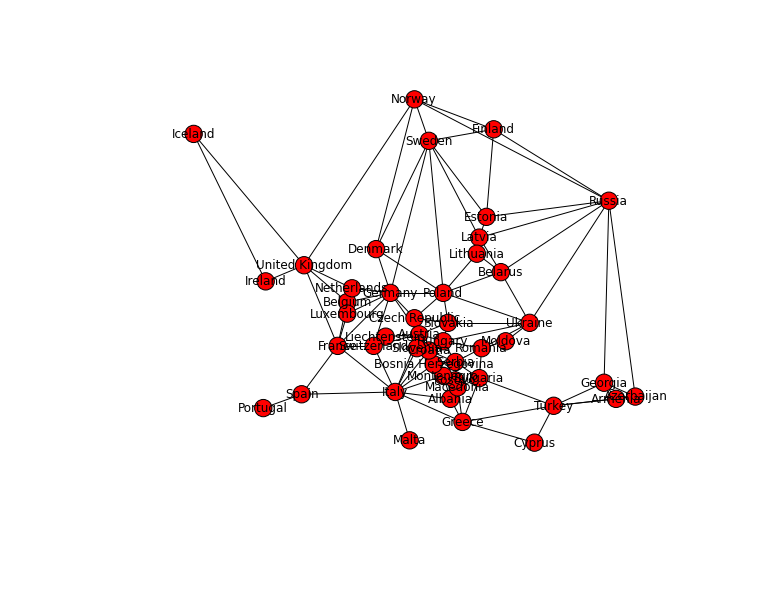

In [6]:
draw_map( europe, (10, 8))

In [ ]:
europe_colors = color_map( europe, ["red", "blue", "green", "yellow"], trace=True)

Here we're testing to see if the adjacent nodes are colored differently:

In [ ]:
edges = europe["edges"]
nodes = europe[ "nodes"]
colors = europe_colors
COLOR = 1

for start, end in edges:
    try:
        assert colors[ start][COLOR] != colors[ end][COLOR]
    except AssertionError:
        print "%s and %s are adjacent but have the same color." % (nodes[ start], nodes[ end])

In [ ]:
draw_map( europe, (10,8), europe_colors)

In [ ]:
europe_colors = color_map( europe, ["red", "blue", "green"], trace=True)
if europe_colors:
     draw_map( europe, (10,8), europe_colors)